In [1]:
from youtubeAPI import get_youtube_api_json
from pymongo import MongoClient # you should install dnspython also
from utils import ProgressBar
from youtubesearchpython import *
from pprint import pprint
from preprocess import preprocessVideoData
import seaborn as sns
from scipy.stats import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import datetime

with open("apikey.txt", encoding="utf8") as f:
    apikey1 = f.readline().strip()
    apikey2 = f.readline().strip()

with open("mongodb.txt") as f:
    mongodb_uri = f.readline().strip()

client = MongoClient(mongodb_uri)
db = client["youtube"]
searchData = db["searchData"]

In [ ]:
videosSearch = VideosSearch("")
pprint(videosSearch.result())

In [ ]:
suggestionData = db["suggestionData"]
suggestions = Suggestions(language="kr", region="KR")

In [ ]:
hangul = re.compile("[^가-힣]+")

In [ ]:
total_data = set()
# for i in range(44032, 55216):
start, end = 54000, 55216
error_count = 0
bar = ProgressBar(end - start)
for i in range(start, end):
    bar.next()
    total_data.add(chr(i))
    try:
        data = suggestions.get(chr(i), mode=ResultMode.dict)
        for j in data["result"]:
            if len(hangul.findall(j)) == 0:
                total_data.add(j)
    except:
        error_count += 1
total_data = list(total_data)
total_data.sort()
print(error_count, total_data)

In [ ]:
suggestionData.insert_one({"result": total_data})

In [ ]:
all_data = list(suggestionData.find())
finalSuggestionData = db["finalSuggestionData"]
total_search_data = set()
for data in all_data:
    for keyword in data["result"]:
        total_search_data.add(keyword)
total_search_data = list(total_search_data)
total_search_data.sort()
print(len(total_search_data))

In [ ]:
finalSuggestionData.drop()

In [ ]:
divide = 50
size = len(total_search_data) // divide + 1
for i in range(divide):
    finalSuggestionData.insert_one(
        {"id": i, "result": total_search_data[size * i : min(size * (i + 1), len(total_search_data))]}
    )

In [ ]:
Video.get("MhQKe-aERsU")

In [ ]:
finalSuggestionData = db["finalSuggestionData"]

for data_num in range(37, 50):
    # data_num = 8
    total = finalSuggestionData.find_one({"id": data_num})["result"]
    id_collection = set()
    bar = ProgressBar(len(total))
    error_count = 0
    for target in total:
        bar.next()
        customSearch = CustomSearch(target, "CAMSAhAB", language="kr", region="KR")
        while True:
            search_result = customSearch.result()["result"]
            if len(search_result) == 0:
                break
            for result in search_result:
                try:
                    viewCount = int(result["viewCount"]["text"].split(" views")[0].replace(",", ""))
                    if viewCount < 10**6:
                        break
                    id_collection.add(result["id"])
                except:
                    continue
            else:
                customSearch.next()
                continue
            break
    print("count:",data_num, error_count, len(id_collection))
    videoIdData = db["videoIdData"]
    videoIdData.insert_one({"id":data_num, "result": list(id_collection)})

In [ ]:
print(list(id_collection))

In [ ]:
duplicate_datas = list(videoIdData.find())
remove_duplicate = set()
for duplicate_data in duplicate_datas["result"]:
    for id in duplicate_data:
        remove_duplicate.add(id)
remove_duplicate = list(remove_duplicate)
finalVideoIdData = db["finalVideoIdData"]
divide = 50
size = len(remove_duplicate) // divide + 1
for i in range(divide):
    finalVideoIdData.insert_one(
        {"id": i, "result": remove_duplicate[size * i : min(size * (i + 1), len(remove_duplicate))]}
    )

In [ ]:
global_query = {"key": apikey1, "maxResults": 100, "regionCode": "KR"}


def get_video(query):
    final_query = {
        **global_query,
        **query,
        "part": "snippet, contentDetails, status, statistics, player, topicDetails, recordingDetails",
    }
    return get_youtube_api_json("videos", final_query)

In [ ]:
videoInfoData = db["videoInfoData"]
final_total_id = list(finalVideoIdData.find())
for ids in final_total_id["result"]:
    count = 0
    result = []
    while len(ids) > 50 * count:
        query = {"id": ",".join(ids[50 * count : min(50 * (count + 1), len(ids))])}
        result.extend(get_video(query).get("items", []))
        count += 1
    videoInfoData.insert_one({"result": result})

In [ ]:
finalVideoInfoData = db["finalVideoInfoData"]
videoInfoData = db["videoInfoData"]
init_data = list(videoInfoData.find({"id":0}))
preprocessed_data = []
for data in init_data[0]["result"]:
    pprint(data)
    break

In [ ]:
Video.get("SN-E6bO0Te0")

In [ ]:
get_video({"id":"SN-E6bO0Te0"})

In [ ]:
finalVideoInfoData = db["finalVideoInfoData"]
videoInfoData = db["videoInfoData"]
preprocessed_data = []
bar = ProgressBar(50)
for i in range(50):
    bar.next()
    init_data = videoInfoData.find_one({"id":i})
    for data in init_data["result"]:
            preprocessed_data.append(preprocessVideoData(data))

In [ ]:
len(preprocessed_data)

In [ ]:
from preprocess import isKoreanVideo
koreanVideo = []
for data in preprocessed_data:
    if isKoreanVideo(data):
        koreanVideo.append(data)
print(len(koreanVideo))

In [ ]:
finalVideoInfoData = db["finalVideoInfoData"]
finalVideoInfoData.insert_many(koreanVideo)

In [2]:
finalVideoInfoData = db["finalVideoInfoData"]
data = list(finalVideoInfoData.find())

df = pd.DataFrame(data)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175442 entries, 0 to 175441
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   _id                   175442 non-null  object        
 1   id                    175442 non-null  object        
 2   duration              175442 non-null  int64         
 3   caption               175442 non-null  bool          
 4   publishedAt           175442 non-null  datetime64[ns]
 5   channelId             175442 non-null  object        
 6   title                 175442 non-null  object        
 7   description           175442 non-null  object        
 8   channelTitle          175442 non-null  object        
 9   tags                  153214 non-null  object        
 10  categoryId            175442 non-null  int64         
 11  liveBroadcastContent  175442 non-null  bool          
 12  defaultAudioLanguage  121539 non-null  object        
 13 

In [5]:
print(len(df[df.commentCount.isnull()]))
print(len(df[df.commentCount==0]))
hasComment = df[df.commentCount.notnull() & df.commentCount != 0].copy()
print(len(hasComment))

6419
14164
154859


C:\Users\songy\scoop\apps\miniconda3\current\envs\youtube-api\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


shape:0.9550005497382943, floc:-5.712217693331209e-05, scale:0.0006662620633904155
KstestResult(statistic=0.012348849336762724, pvalue=6.095232146642431e-21)


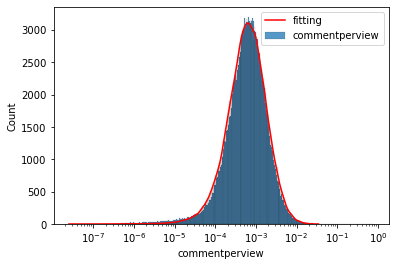

In [84]:
hasComment["commentperview"] = hasComment.commentCount/hasComment.viewCount
sns.histplot(hasComment, x=hasComment.commentperview, log_scale=True)


params = lognorm.fit(hasComment["commentperview"])
sns.histplot([lognorm.rvs(*params) for _ in range(len(hasComment))], log_scale=True, color="r", alpha=0, kde=True)
plt.legend(labels = ['fitting','commentperview'])
print(f"shape:{params[0]}, floc:{params[1]}, scale:{params[2]}")
print(kstest(hasComment["commentperview"], 'lognorm', params, len(hasComment))) # p-test not working because dataset is too large so p-test is too powerful

<AxesSubplot:ylabel='Count'>

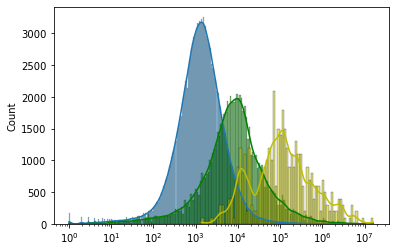

In [81]:
commentCount1 = hasComment.commentCount.tolist()
commentCount2 = hasComment[hasComment.viewCount>10000000].commentCount.tolist()*10
commentCount3 = hasComment[hasComment.viewCount>100000000].commentCount.tolist()*100
sns.histplot(commentCount1, log_scale=True,  kde=True)
sns.histplot(commentCount2, log_scale=True,  kde=True, color='g')
sns.histplot(commentCount3, log_scale=True,  kde=True, color="y")

[24 20 10 22 23 15  1 19 29 28 17 27  2 25 26]


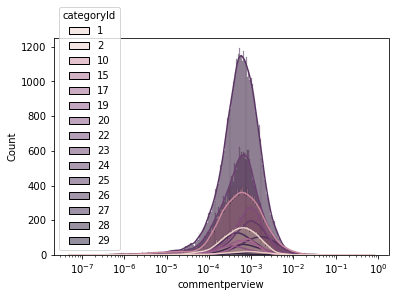

In [64]:
sns.histplot(hasComment, x=hasComment.commentperview, log_scale=True, kde=True, hue="categoryId")

In [83]:
categories = hasComment.categoryId.unique()
videoCategories = db["videoCategories"]
data = []
for category in categories:
    if not videoCategories.find_one({"id":str(category)}):
        continue
    name = videoCategories.find_one({"id":str(category)})["snippet"]["title"]
    params = lognorm.fit(hasComment[hasComment.categoryId==int(category)]["commentperview"])
    data.append([name, *params])
    # categoryfit.append([name, *params])
    # print(f"shape:{params[0]}, floc:{params[1]}, scale:{params[2]}")
categoryfit = pd.DataFrame(data=data, columns=["name", "shape", "floc", "scale"])
categoryfit.sort_values("scale", ascending=False)

,name,shape,floc,scale
5,Pets & Animals,0.100425,-0.006356,0.007244
13,Howto & Style,0.190506,-0.002315,0.002891
9,Sports,0.244240,-0.002018,0.002769
7,Travel & Events,0.243562,-0.001695,0.002203
12,News & Politics,0.824506,-0.000178,0.001645
8,Science & Technology,0.765480,-0.000250,0.001001
1,Gaming,0.742314,-0.000142,0.001000
4,Comedy,0.798735,-0.000090,0.001000
10,Education,0.950150,-0.000075,0.000711
0,Entertainment,0.912982,-0.000054,0.000627


shape:1.5001740108373913, floc:990848.7384477272, scale:827460.4618994491


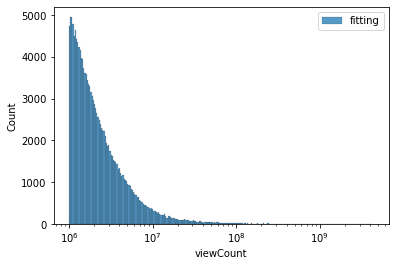

In [196]:
sns.histplot(hasComment, x=hasComment.viewCount, log_scale=True)
params = lognorm.fit(hasComment.viewCount)
plt.legend(labels = ['fitting','viewCount'])
print(f"shape:{params[0]}, floc:{params[1]}, scale:{params[2]}")
# params =[ 1.00000048e+00, -5.46725517e+02,  2.99999990e+05]
# sns.histplot([lognorm.rvs(*params) for _ in range(300000)], log_scale=True, color="r", alpha=0, kde=True)

In [194]:
from scipy import optimize

y_data, x_data= np.histogram(hasComment.viewCount, bins="auto")
def piecewise_lognorm(x, shape, floc, scale):
    return np.piecewise(x, [x < 10**6], [0 , lambda x:lognorm.pdf(x, shape, floc, scale)])

counter = 0
for i,x in enumerate(x_data):
    shape, floc, scale = 1.5001740108373913, 990848.7384477272, 827460.4618994491
    if counter >= 100:
        break
    counter += 1


print(optimize.curve_fit(piecewise_lognorm, x_data[:-1], y_data, bounds=([1,-np.Inf,100000], [10,np.Inf, 300000])))

(array([ 1.00000048e+00, -5.46725517e+02,  2.99999990e+05]), array([[ 1.64235824e+31,  5.59830367e+38, -2.82247240e+37],
       [ 5.59830367e+38,  1.93253106e+46, -9.64412198e+44],
       [-2.82247240e+37, -9.64412198e+44,  4.85281261e+43]]))


<AxesSubplot:ylabel='Count'>

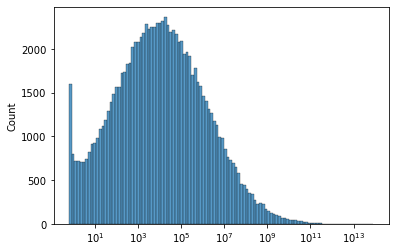

In [158]:
params = [5.01952186e+00, 6.22935049e-01, 1.00000516e+04]
sns.histplot([lognorm.rvs(*params) for _ in range(100000)], log_scale=True)

In [ ]:
import seaborn as sns

# r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,
# r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,
# r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,
# r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,
# r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,
# r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,
# r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계

hasValues = df[df.commentCount.notnull() & df.commentCount != 0 & df.likeCount.notnull()][["viewCount", "commentCount", "likeCount"]].copy()
corr = hasValues.corr(method="pearson")
print(corr, sep="\n\n")
sns.pairplot(hasValues[["viewCount", "commentCount", "likeCount"]])

In [198]:
print(len(df[df.liveBroadcastContent]))
print(len(df[~df.liveBroadcastContent]))
notLive = df[~df.liveBroadcastContent].copy()

12
175430


76 12 54
200 200
3977.6458184973194 11.48751911695992 943.0617518471981
[8.25695171e+02 9.20041737e+02 1.02323593e+03 1.13241144e+03
 1.25004822e+03 1.39335847e+03 1.59647432e+03 1.90083759e+03
 2.33144330e+03 2.86364967e+03 3.40308437e+03 3.81088637e+03
 3.97764582e+03 3.89214605e+03 3.64008479e+03 3.33667316e+03
 3.05909751e+03 2.82862618e+03 2.63640447e+03 2.47503233e+03
 2.34957444e+03 2.27241139e+03 2.25662389e+03 2.30867316e+03
 2.41966880e+03 2.57618203e+03 2.79131614e+03 3.08882644e+03
 3.42092413e+03 3.64976907e+03 3.66398372e+03 3.47933263e+03
 3.19570843e+03 2.89580387e+03 2.60620868e+03 2.32298066e+03
 2.04680938e+03 1.79403120e+03 1.58211390e+03 1.41197113e+03
 1.26917958e+03 1.13897543e+03 1.01530123e+03 8.99324356e+02
 7.94982902e+02 7.04855859e+02 6.27062757e+02 5.56153541e+02
 4.88260716e+02 4.25386428e+02 3.74032680e+02 3.39208905e+02
 3.19930584e+02 3.11309538e+02 3.10723647e+02 3.18927943e+02
 3.32218161e+02 3.36724762e+02 3.17656484e+02 2.74910045e+02
 2.24120833e+

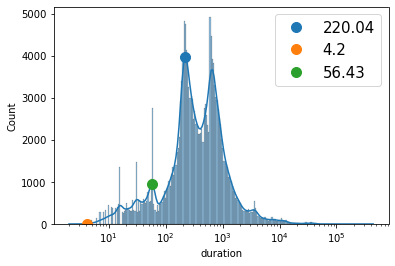

In [256]:
ax = sns.histplot(notLive, x=notLive.duration, kde=True, log_scale=True)
x = ax.lines[0].get_xdata() 
y = ax.lines[0].get_ydata()
maxid1 = np.argmax(y)
maxid2 = np.argmax(y[x>100])
maxid3 = np.argmax(y[x<100]) 
print(maxid1, maxid2, maxid3)
print(len(x), len(y))
print(y[maxid1], y[maxid2], y[maxid3])
print(y[x>100])
print(x>100000)
plt.plot(x[maxid1], y[maxid1], 'o', label=round(x[maxid1],2), ms=10)
plt.plot(x[maxid2], y[maxid2], 'o', label=round(x[maxid2],2), ms=10)
plt.plot(x[maxid3], y[maxid3], 'o', label=round(x[maxid3],2), ms=10)

plt.legend(fontsize=15)
plt.show()

<AxesSubplot:xlabel='publishedAt', ylabel='Count'>

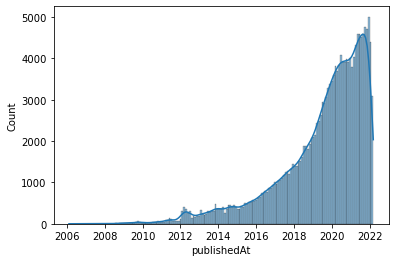

In [200]:
sns.histplot(df, x=df.publishedAt, kde=True)

<AxesSubplot:xlabel='publishedAt', ylabel='Count'>

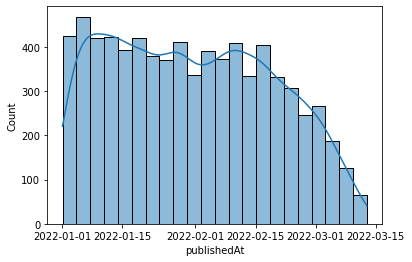

In [201]:
sns.histplot(df, x=df[df.publishedAt>=datetime.datetime(2022,1,1)].publishedAt, kde=True)

<AxesSubplot:xlabel='publishedAt', ylabel='Count'>

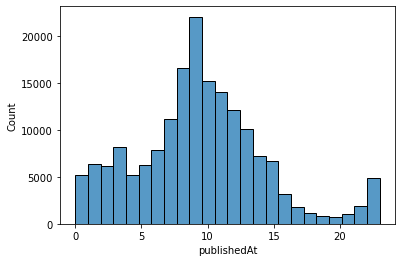

In [202]:
def todaytime(data:datetime.datetime):
    return data.hour*3600 + data.minute*60 + data.second


primetime = df.publishedAt.copy().apply(lambda x:x.hour)
sns.histplot(primetime, bins=24)

In [204]:
print(len(df[df.tags.isnull()]))
hasTag = df[df.tags.notnull()].copy()

22228


In [211]:
from collections import Counter
total_tags = []
for tags in hasTag.tags:
    total_tags.extend(tags)
total_tag_counter = Counter(total_tags)
print(total_tag_counter.most_common(100))
tag_df = pd.DataFrame(list(total_tag_counter.items()), columns=["name", "count"])
tag_df.sort_values("count", ascending=False).head(10)
# got IOPub data rate exceeded. error

[('먹방', 10083), ('장난감', 5535), ('kpop', 5483), ('애니메이션', 5379), ('yt:cc=on', 4625), ('mukbang', 4611), ('드라마', 4389), ('어린이', 4238), ('키즈', 4012), ('tvN', 3903), ('SBS', 3871), ('아이돌', 3770), ('MBC', 3708), ('예능', 3579), ('레전드', 3325), ('kids', 3213), ('유재석', 3157), ('asmr', 3131), ('ASMR', 3079), ('개그', 3042), ('Kpop', 3036), ('엠넷', 3030), ('꿀잼', 2898), ('코미디', 2835), ('KBS', 2805), ('유아', 2715), ('게임', 2700), ('웃긴영상', 2662), ('놀이', 2659), ('뽀로로', 2609), ('JTBC', 2609), ('Mnet', 2608), ('리얼사운드', 2597), ('음악', 2593), ('라이브', 2521), ('마인크래프트', 2497), ('교육', 2458), ('동요', 2353), ('toy', 2352), ('노래', 2342), ('한국', 2327), ('댄스', 2325), ('만화', 2284), ('toys', 2280), ('korea', 2244), ('디글', 2239), ('요리', 2157), ('영화', 2145), ('브이로그', 2131), ('방탄소년단', 2130), ('웃긴', 2118), ('마크', 2117), ('k-pop', 2109), ('케이팝', 2085), ('korean', 2080), ('가족', 2065), ('Diggle', 2049), ('KPOP', 1984), ('타요', 1955), ('뉴스', 1900), ('뮤비', 1898), ('몰카', 1895), ('animation', 1895), ('하하', 1875), ('토이', 1866), ('Kore

,name,count
65,먹방,10083
2,장난감,5535
117,kpop,5483
1240,애니메이션,5379
1302,yt:cc=on,4625
356,mukbang,4611
1315,드라마,4389
596,어린이,4238
1252,키즈,4012
1124,tvN,3903


In [10]:
total_categories = []
for categories in df.topicCategories:
    total_categories.extend(categories)
total_category_counter = Counter(total_categories)
print(total_category_counter.most_common(100))

[('Lifestyle_(sociology)', 52848), ('Entertainment', 50560), ('Music', 40987), ('Music_of_Asia', 34442), ('Film', 27348), ('Pop_music', 25597), ('Food', 21162), ('Television_program', 14929), ('Hobby', 11159), ('Video_game_culture', 10685), ('Society', 7900), ('Action-adventure_game', 6839), ('Role-playing_video_game', 5560), ('Hip_hop_music', 5479), ('Action_game', 5432), ('Sport', 3723), ('Pet', 3556), ('Strategy_video_game', 3272), ('Electronic_music', 2642), ('Performing_arts', 2474), ('Vehicle', 2062), ('Politics', 1721), ('Physical_fitness', 1549), ('Technology', 1499), ('Association_football', 1297), ('Health', 1200), ('Knowledge', 1047), ('Rhythm_and_blues', 830), ('Rock_music', 750), ('Fashion', 676), ('Humour', 597), ('Classical_music', 526), ('Soul_music', 519), ('Christian_music', 513), ('Baseball', 381), ('Independent_music', 353), ('Religion', 304), ('Golf', 290), ('Racing_video_game', 279), ('Tourism', 263), ('Puzzle_video_game', 249), ('Basketball', 240), ('Sports_game'

In [13]:
total2_categories = []
for categories in df.categoryId:
    total2_categories.append(categories)
total2_category_counter = Counter(total2_categories)
print(total2_category_counter.most_common(100))

[(24, 61050), (22, 29593), (10, 21837), (1, 12790), (20, 10979), (23, 8612), (27, 6588), (26, 6517), (25, 5067), (17, 3923), (15, 3061), (19, 2693), (2, 1305), (28, 942), (29, 485)]
